In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.signal as signal
import os

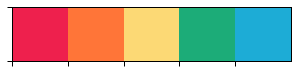

In [3]:
sns.set_context('paper')

pal = sns.crayon_palette(['Red', 'Orange', 'Goldenrod', 'Green', 'Cerulean'])
sns.set_palette(pal)
sns.palplot(pal)

In [4]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notch, filtered, Q, fs):
    max_harmonic = int(nyquist/notch)
    min_harmonic = 1
    for i in np.arange(1, max_harmonic):
        #print(notch * i)
        f0 = notch * i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
    j = 1
    while (notch / j) > 1:
        #print(notch * i)
        f0 = notch / i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
        j += 1
    return filtered

# Comparing frequency spectra across scans across denoising approaches
## ECG collected during multiband, single-echo EPI sequence

In [5]:
data_fname = '../data/raw/mbse-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=0)
basename = data_fname.split('/')[-1][:-4]

slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = 2000.

nyquist = fs/2
Q = 100

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
fft_ecg_nomri = signal.decimate(np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000]), 10)
freq_ecg_nomri = signal.decimate(np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], 
                                                d=0.0005), 10)

limit = np.where(freq_ecg_nomri >= 60)[0][0]

In [7]:
scans = timeseries['scan'].unique()
scans = [x for x in scans if not np.isnan(x)]
print(scans)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


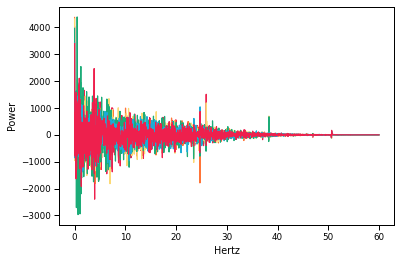

In [8]:
fft_ecg = {}
freq = {}
ecg = {}
for scan in scans:
    ecg[scan] = timeseries[timeseries['scan'] == scan]['ECG']
    fft_ecg[scan] = signal.decimate(np.fft.fft(ecg[scan]), 10)
    freq[scan] = signal.decimate(np.fft.fftfreq(ecg[scan].shape[-1], d=0.0005), 10)
    limit = np.where(freq[scan].real >= 60)[0][0]
    g = sns.lineplot(freq[scan][:limit], fft_ecg[scan].real[:limit])
    g.set_xlabel('Hertz')
    g.set_ylabel('Power')

In [9]:
np.where(freq[scan].real >= 60)[0][0]

1822

In [10]:
steps_in_denoising = ['raw', 'BIOPAC', 'MB-BIOPAC', 'Bottenhorn']

In [11]:
index = pd.MultiIndex.from_product([scans, steps_in_denoising], names=['scan', 'step'])

In [12]:
#msc = {}
dist = pd.DataFrame(index=index, columns=index, dtype=float)
for scan1 in scans:
    fft1 = fft_ecg[scan1].real
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'raw'), 'noMR'] = corr
    
    notch = slices / tr
    filtered = comb_band_stop(notch, ecg[scan1], Q, fs)
    fft_bpfilt1 = signal.decimate(np.fft.fft(filtered),10)
    corr = np.corrcoef(abs(fft_bpfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'BIOPAC')] = corr
    dist.at[(scan1, 'BIOPAC'), (scan1, 'raw')] = corr
    
    notch = slices / mb / tr
    filtered = comb_band_stop(notch, ecg[scan1], Q, fs)
    fft_bpmbfilt1 = signal.decimate(np.fft.fft(filtered), 10)
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
    
    notches = {'slices': slices / mb / tr, 
               'tr': 1 / tr}
    filtered1 = ecg[scan1]
    for notch in notches:
        filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)
    
    fft_bottfilt1 = signal.decimate(np.fft.fft(filtered1), 10)
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr

    for scan2 in scans:
        fft2 = fft_ecg[scan2].real
        corr =  np.corrcoef(abs(fft1[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'raw')] = corr
        dist.at[(scan1, 'raw'), (scan2, 'raw')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'raw'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bottfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'Bottenhorn')] = corr

        notch = slices / tr
        filtered = comb_band_stop(notch, ecg[scan2], Q, fs)
        fft_bpfilt2 = signal.decimate(np.fft.fft(filtered),10)
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
        #corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        #dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr

        notch = slices / mb / tr
        filtered = comb_band_stop(notch, ecg[scan2], Q, fs)
        fft_bpmbfilt2 = signal.decimate(np.fft.fft(filtered), 10)
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
        
        filtered1 = ecg[scan2]
        for notch in notches:
            filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

        fft_bottfilt2 = signal.decimate(np.fft.fft(filtered1),10)
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bottfilt2[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'Bottenhorn')] = corr

        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr
        
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan1, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan1, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan1, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr

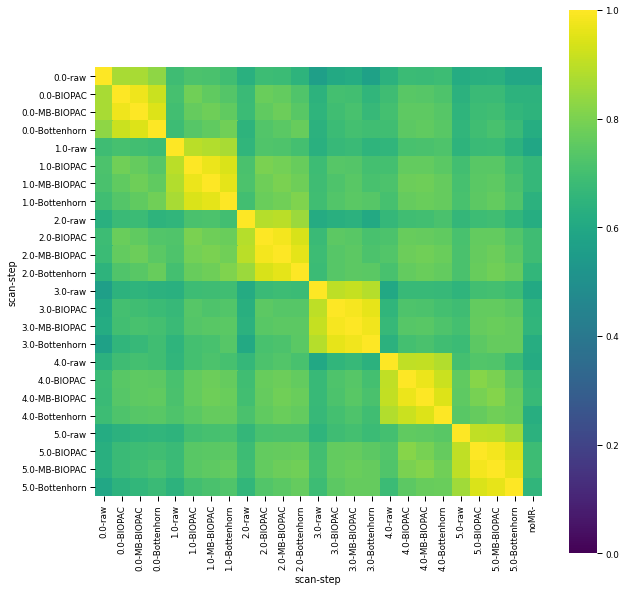

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dist, square=True, vmin=0, cmap='viridis', )
fig.savefig(os.path.join('../figures/fft_correlations-{0}.png'.format(basename)), dpi=300)

In [14]:
dist.sort_values('noMR', axis=0, ascending=False)

scan                  0.0                                      1.0            \
step                  raw    BIOPAC MB-BIOPAC Bottenhorn       raw    BIOPAC   
scan step                                                                      
5.0  MB-BIOPAC   0.635393  0.679487  0.694689   0.707776  0.682060  0.740456   
2.0  BIOPAC      0.684528  0.772953  0.757124   0.727160  0.723004  0.800499   
     MB-BIOPAC   0.683543  0.760691  0.773919   0.746066  0.720335  0.787523   
5.0  BIOPAC      0.629136  0.678017  0.686834   0.693818  0.677550  0.738657   
4.0  MB-BIOPAC   0.679601  0.735443  0.753373   0.756810  0.714701  0.759404   
1.0  BIOPAC      0.716531  0.781537  0.762895   0.735387  0.895914  1.000000   
4.0  BIOPAC      0.681195  0.741395  0.752419   0.749430  0.708254  0.761561   
1.0  MB-BIOPAC   0.713013  0.757566  0.779966   0.754955  0.885897  0.969509   
2.0  Bottenhorn  0.647051  0.723829  0.739196   0.765996  0.701126  0.767042   
5.0  Bottenhorn  0.594188  0.642326  0.659477   0.677901  0.640818  0.698624   
3.0  MB-BIOPAC   0.614766  0.697212  0.710208   0.702815  0.678018  0.731786   
     BIOPAC      0.602388  0.702471  0.692786   0.683436  0.670474  0.735872   
0.0  MB-BIOPAC   0.868519  0.973984  1.000000   0.948422  0.697856  0.762895   
     BIOPAC      0.870166  1.000000  0.973984   0.920236  0.705735  0.781537   
1.0  Bottenhorn  0.691527  0.734241  0.754192   0.782135  0.868314  0.941430   
5.0  raw         0.617184  0.639216  0.650580   0.655563  0.646588  0.696796   
4.0  Bottenhorn  0.684808  0.720723  0.737738   0.740917  0.721992  0.743458   
3.0  Bottenhorn  0.571942  0.655536  0.669351   0.693821  0.648643  0.699870   
2.0  raw         0.636305  0.677227  0.680099   0.647175  0.655559  0.711414   
0.0  Bottenhorn  0.828302  0.920236  0.948422   1.000000  0.685037  0.735387   
4.0  raw         0.638608  0.688633  0.702896   0.694677  0.655408  0.701110   
3.0  raw         0.559428  0.642550  0.652069   0.638291  0.633675  0.687252   
0.0  raw         1.000000  0.870166  0.868519   0.828302  0.689024  0.716531   
1.0  raw         0.689024  0.705735  0.697856   0.685037  1.000000  0.895914   

scan                                       2.0            ...        3.0  \
step            MB-BIOPAC Bottenhorn       raw    BIOPAC  ... Bottenhorn   
scan step                                                 ...              
5.0  MB-BIOPAC   0.752863   0.759869  0.693243  0.760893  ...   0.762626   
2.0  BIOPAC      0.781025   0.770873  0.888337  1.000000  ...   0.709750   
     MB-BIOPAC   0.800329   0.784803  0.897713  0.980669  ...   0.718065   
5.0  BIOPAC      0.743939   0.748552  0.686978  0.759419  ...   0.749461   
4.0  MB-BIOPAC   0.780442   0.773192  0.698776  0.765007  ...   0.713192   
1.0  BIOPAC      0.969509   0.941430  0.711414  0.800499  ...   0.699870   
4.0  BIOPAC      0.774221   0.765128  0.693467  0.766727  ...   0.701447   
1.0  MB-BIOPAC   1.000000   0.959461  0.717289  0.781025  ...   0.707177   
2.0  Bottenhorn  0.779560   0.807813  0.847834  0.939138  ...   0.745406   
5.0  Bottenhorn  0.713793   0.723788  0.657730  0.730104  ...   0.765309   
3.0  MB-BIOPAC   0.739415   0.742568  0.637544  0.739240  ...   0.978202   
     BIOPAC      0.721715   0.729263  0.629090  0.746874  ...   0.963907   
0.0  MB-BIOPAC   0.779966   0.754192  0.680099  0.757124  ...   0.669351   
     BIOPAC      0.757566   0.734241  0.677227  0.772953  ...   0.655536   
1.0  Bottenhorn  0.959461   1.000000  0.698852  0.770873  ...   0.734443   
5.0  raw         0.705435   0.707397  0.660770  0.707567  ...   0.679705   
4.0  Bottenhorn  0.762766   0.764633  0.714005  0.755281  ...   0.692121   
3.0  Bottenhorn  0.707177   0.734443  0.603535  0.709750  ...   1.000000   
2.0  raw         0.717289   0.698852  1.000000  0.888337  ...   0.603535   
0.0  Bottenhorn  0.754955   0.782135  0.647175  0.727160  ...   0.693821   
4.0  raw         0.717157   0.705877  0.667171  0.716432  ...   0.638211   
3.0  raw       

In [15]:
dist.to_csv(os.path.join('../data/fft_correlations-ECG-{0}.csv'.format(basename)))

## ECG collected during multiband, multi-echo EPI sequences

In [16]:
data_fname = '../data/raw/mbme-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=0)
basename = data_fname.split('/')[-1][:-4]

slices = 48
tr = 1.5
mb = 3

cutoff = 120

fs = 2000.

nyquist = fs/2
Q = 100

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
fft_ecg_nomri = signal.decimate(np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000]), 10)
freq_ecg_nomri = signal.decimate(np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], 
                                                d=0.0005), 10)

limit = np.where(freq_ecg_nomri >= 60)[0][0]

In [18]:
scans = timeseries['scan'].unique()
scans = [x for x in scans if not np.isnan(x)]
print(scans)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


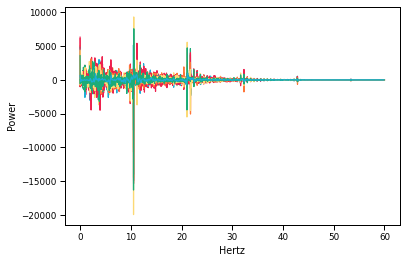

In [19]:
fft_ecg = {}
freq = {}
ecg = {}
for scan in scans:
    ecg[scan] = timeseries[timeseries['scan'] == scan]['ECG']
    fft_ecg[scan] = signal.decimate(np.fft.fft(ecg[scan]), 10)
    freq[scan] = signal.decimate(np.fft.fftfreq(ecg[scan].shape[-1], d=0.0005), 10)
    limit = np.where(freq[scan].real >= 60)[0][0]
    g = sns.lineplot(freq[scan][:limit], fft_ecg[scan].real[:limit])
    g.set_xlabel('Hertz')
    g.set_ylabel('Power')

In [20]:
index = pd.MultiIndex.from_product([scans, steps_in_denoising], names=['scan', 'step'])

In [21]:
#msc = {}
dist = pd.DataFrame(index=index, columns=index, dtype=float)
for scan1 in scans:
    fft1 = fft_ecg[scan1].real
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'raw'), 'noMR'] = corr
    
    notch = slices / tr
    filtered = comb_band_stop(notch, ecg[scan1], Q, fs)
    fft_bpfilt1 = signal.decimate(np.fft.fft(filtered),10)
    corr = np.corrcoef(abs(fft_bpfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'BIOPAC')] = corr
    dist.at[(scan1, 'BIOPAC'), (scan1, 'raw')] = corr
    
    notch = slices / mb / tr
    filtered = comb_band_stop(notch, ecg[scan1], Q, fs)
    fft_bpmbfilt1 = signal.decimate(np.fft.fft(filtered), 10)
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
    
    notches = {'slices': slices / mb / tr, 
               'tr': 1 / tr}
    filtered1 = ecg[scan1]
    for notch in notches:
        filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)
    
    fft_bottfilt1 = signal.decimate(np.fft.fft(filtered1), 10)
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
    dist.at[(scan1, 'Bottenhorn'), 'noMR'] = corr
    
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft1[:14000]))[0][1]
    dist.at[(scan1, 'raw'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'raw')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
    dist.at[(scan1, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
    corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
    dist.at[(scan1, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
    dist.at[(scan1, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr

    for scan2 in scans:
        fft2 = fft_ecg[scan2].real
        corr =  np.corrcoef(abs(fft1[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'raw')] = corr
        dist.at[(scan1, 'raw'), (scan2, 'raw')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'raw'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft2[:14000]), abs(fft_bottfilt1[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan1, 'Bottenhorn')] = corr

        notch = slices / tr
        filtered = comb_band_stop(notch, ecg[scan2], Q, fs)
        fft_bpfilt2 = signal.decimate(np.fft.fft(filtered),10)
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan1, 'Bottenhorn')] = corr
        #corr = np.corrcoef(abs(fft1[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        #dist.at[(scan2, 'BIOPAC'), (scan1, 'raw')] = corr

        notch = slices / mb / tr
        filtered = comb_band_stop(notch, ecg[scan2], Q, fs)
        fft_bpmbfilt2 = signal.decimate(np.fft.fft(filtered), 10)
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bpmbfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan1, 'Bottenhorn')] = corr
        
        filtered1 = ecg[scan2]
        for notch in notches:
            filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

        fft_bottfilt2 = signal.decimate(np.fft.fft(filtered1),10)
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_ecg_nomri[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), 'noMR'] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'MB-BIOPAC')] = corr
        corr = np.corrcoef(abs(fft_bottfilt1[:14000]), abs(fft_bottfilt2[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'Bottenhorn')] = corr

        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft2[:14000]))[0][1]
        dist.at[(scan2, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan2, 'Bottenhorn'), (scan1, 'raw')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt2[:14000]))[0][1]
        dist.at[(scan2, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt2[:14000]))[0][1]
        dist.at[(scan2, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr
        
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft1[:14000]))[0][1]
        dist.at[(scan1, 'raw'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpfilt1[:14000]))[0][1]
        dist.at[(scan1, 'BIOPAC'), (scan2, 'Bottenhorn')] = corr
        corr = np.corrcoef(abs(fft_bottfilt2[:14000]), abs(fft_bpmbfilt1[:14000]))[0][1]
        dist.at[(scan1, 'MB-BIOPAC'), (scan2, 'Bottenhorn')] = corr

In [22]:
len(fft2)

14827

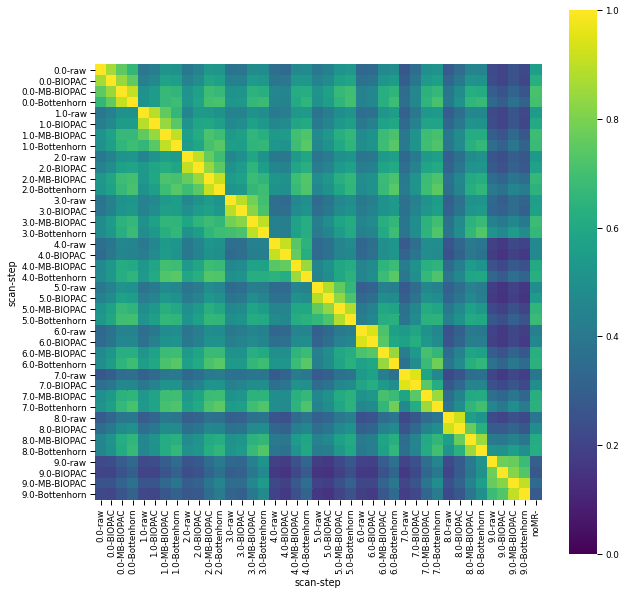

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dist, square=True, vmin=0, cmap='viridis', )
fig.savefig(os.path.join('../figures/fft_correlations-{0}.png'.format(basename)), dpi=300)

In [24]:
dist.sort_values('noMR', axis=0, ascending=False)

scan                  0.0                                      1.0            \
step                  raw    BIOPAC MB-BIOPAC Bottenhorn       raw    BIOPAC   
scan step                                                                      
0.0  MB-BIOPAC   0.750787  0.847394  1.000000   0.911303  0.502981  0.548817   
     Bottenhorn  0.660655  0.753957  0.911303   1.000000  0.509439  0.548374   
1.0  MB-BIOPAC   0.511987  0.574233  0.668939   0.668760  0.754918  0.841017   
3.0  MB-BIOPAC   0.484094  0.545263  0.644357   0.665485  0.510443  0.567031   
5.0  Bottenhorn  0.532693  0.588943  0.692330   0.698722  0.515189  0.560806   
1.0  Bottenhorn  0.501049  0.558011  0.653028   0.684596  0.663906  0.739615   
2.0  MB-BIOPAC   0.533542  0.588897  0.690514   0.700241  0.530981  0.595226   
3.0  Bottenhorn  0.476897  0.532956  0.632225   0.679097  0.490957  0.532828   
5.0  MB-BIOPAC   0.517182  0.569687  0.669236   0.651848  0.490181  0.533907   
2.0  Bottenhorn  0.522814  0.569236  0.669237   0.707144  0.505803  0.560260   
6.0  Bottenhorn  0.487694  0.548176  0.651961   0.684828  0.554241  0.597436   
7.0  Bottenhorn  0.515509  0.562370  0.664866   0.708865  0.537394  0.579181   
     MB-BIOPAC   0.494396  0.542839  0.639736   0.649460  0.529861  0.579330   
0.0  BIOPAC      0.864359  1.000000  0.847394   0.753957  0.432215  0.471311   
6.0  MB-BIOPAC   0.469668  0.527175  0.625519   0.628321  0.519943  0.577424   
4.0  Bottenhorn  0.478482  0.534690  0.623060   0.649400  0.541373  0.606216   
8.0  Bottenhorn  0.450746  0.506580  0.610141   0.669096  0.468458  0.508264   
     MB-BIOPAC   0.455649  0.515278  0.617368   0.655234  0.465095  0.512979   
4.0  MB-BIOPAC   0.472550  0.533773  0.613996   0.604534  0.528495  0.587155   
1.0  BIOPAC      0.420741  0.471311  0.548817   0.548374  0.894503  1.000000   
2.0  BIOPAC      0.441476  0.489448  0.573427   0.579934  0.540250  0.592454   
3.0  BIOPAC      0.387434  0.436752  0.516528   0.529252  0.448800  0.484722   
0.0  raw         1.000000  0.864359  0.750787   0.660655  0.394811  0.420741   
3.0  raw         0.386092  0.430958  0.510208   0.523978  0.442212  0.471759   
5.0  BIOPAC      0.437382  0.484078  0.568872   0.554300  0.418108  0.449817   
1.0  raw         0.394811  0.432215  0.502981   0.509439  1.000000  0.894503   
2.0  raw         0.403080  0.441100  0.513747   0.525039  0.453669  0.514117   
7.0  BIOPAC      0.356255  0.391707  0.461792   0.468737  0.398195  0.437920   
5.0  raw         0.404141  0.437955  0.514507   0.505935  0.382826  0.408930   
8.0  BIOPAC      0.350305  0.402684  0.483515   0.502594  0.357736  0.399347   
4.0  BIOPAC      0.345072  0.395570  0.455617   0.447680  0.420763  0.473143   
     raw         0.361962  0.393778  0.458240   0.454447  0.408086  0.458945   
6.0  BIOPAC      0.344889  0.386017  0.458861   0.461378  0.377023  0.431252   
     raw         0.337855  0.374041  0.443409   0.446489  0.359116  0.405279   
7.0  raw         0.269611  0.294006  0.350760   0.356939  0.315318  0.343216   
8.0  raw         0.281739  0.326952  0.391473   0.405324  0.291030  0.331338   
9.0  MB-BIOPAC   0.257475  0.256242  0.320524   0.376330  0.259405  0.262003   
     raw         0.224193  0.231614  0.289517   0.338779  0.222734  0.229193   
     Bottenhorn  0.220286  0.209857  0.264736   0.313799  0.217594  0.208576   
     BIOPAC      0.201595  0.204204  0.255060   0.296171  0.200767  0.203030   

scan                                       2.0            ...        7.0  \
step            MB-BIOPAC Bottenhorn       raw    BIOPAC  ... Bottenhorn   
scan step                                                 ...              
0.0  MB-BIOPAC   0.668939   0.653028  0.513747  0.573427  ...   0.664866   
     Bottenhorn  0.668760   0.684596  0.525039  0.579934  ...   0.708865   
1.0  MB-BIOPAC   1.000000   0.904677  0.555294  0.616952  ...   0.703839   
3.0  MB-BIOPAC   0.654747   0.651671  0.591137  0.651354  ...   0.692460   
5.0  Bottenhorn  0.658518  

In [25]:
dist.to_csv(os.path.join('../data/fft_correlations-ECG-{0}.csv'.format(basename)))